In [7]:
!pip install iapws

  Using cached iapws-1.5.4-py3-none-any.whl


In [8]:
from iapws import IAPWS97

You are told to design a concentrated solar power plant with a capacity of 10 MW. During daytime, the direct normal irradiance is 800 to 1000 W/m$^2$. The plant consists of the following components:

- parabolic trough mirrors, arranged in rows to track the sun along a single axis. The mirrors have a motorized tracking system to maintain optimal orientation with the sun during daytime. The optical concentration is 70. 
- receiver tubes, which are positioned at the focal line of the troughs to absorb concentrated sunlight heating the heat transfer fluid. The fluid is a thermal oil, and the inlet and outlet temperatures are 200$^\circ$C and 400$^\circ$C, respectively.

The heat transfer fluid is pumped through a boiler, which heated water to generate high-pressure steam. This steam drives a turbine, which is connected to a generator, that produces electricity. The steam that exits the turbine then enters a condenser, which is at a pressure of 75 kPa, and is cooled using water. A pump recirculates the condensed water back to the boiler. 

- The boiler produces steam with a temperature of 350 $^\circ$C and 100 bar.
- For this simple analysis, we will not consider a thermal storage system.

Please answer the following questions:
- (a) What is the mass flow rate of the heat transfer fluid?
- (b) What is the thermal efficiency of the power plant? Assume that the cycle is an ideal Rankine cycle.

Bonus:
- What is the approximate land area required to install the parabolic trough mirrors?

#### Part (a)

The optical concentration is 70:

$$C_\text{opt} = \frac{\text{Average flux over the receiver}}{\text{Flux over the aperture (insolation)}} $$



We are told that the insolation ranges from 800 to 1000 W/m$^{2}$. Let us take an average value of $P_\text{in}=$900 W/m$^{2}$. With this we can determine the average flux over the receiver as $C_\text{opt} P_\text{in} = 900*70 = 63000$ W/m$^{2}$ .

In [12]:
Qin_WperM2 = 63000

We can estimate the necessary heat required to produce 10 MW of power by assuming an initial value of thermal efficiency. Here we assume 35\%.

In [13]:
eta_guess = 0.35
Wout_MW = 10
Wout_W = Wout_MW*1e6

Qin_W = Wout_W/eta_guess
Areceiver_m2 = Qin_W/Qin_WperM2; print(Areceiver_m2)

453.514739229025


For the heat transfer fluid, we would like to use one that is stable in the temperature range mentioned above. One option is silicone fluids, e.g., DOW Syltherm. The properties for this can be determined using [CoolProp](http://www.coolprop.org/fluid_properties/Incompressibles.html).

In [29]:
# name for syltherm on CoolProp; this fluid is not installed as a default fluid though
# fluid_htf = 'S800'

T5_C = 200 # inlet temperature
T6_C = 400 # outlet temperature

# we assume that the heat transfer fluid is incompressible. 
# Therefore, assuming the fluid is a silicone oil, we can use its specific heat:
cp_JperKgPerK = 1510

q56_JperKg = cp_JperKgPerK*(T6_C - T5_C)#; print(q12_JperKg)

mdot56_kgPerS = Qin_W/q56_JperKg

print('(a) The mass flow rate of the heat transfer fluid is: {0:1.2f} kg/s.'.format(mdot56_kgPerS))

(a) The mass flow rate of the heat transfer fluid is: 94.61 kg/s.


#### Part (b)

At steady state, and assuming no thermal storage, the heat transferred into the heat transfer fluid must be transferred out to the boiler. 

In [44]:
Q23_W = Qin_W

In [49]:
# State 3
T3_C = 350
T3_K = T3_C+273.15
p3_bar = 100
p3_MPa = p2_bar/10

state3 = IAPWS97(P=p3_MPa, T=T3_K)

# You can use "dot" notation to determine properties like specific enthalpy or specific entropy
h3_kJperKg = state3.h
s3_kJperKgperK = state3.s

In [57]:
# State 4

# given above
p4_kPa = 75
p4_MPa = p4_kPa/1000

# assume isentropic turbine:
s4_kJperKgperK = s3_kJperKgperK
state4 = IAPWS97(P=p4_MPa, s=s4_kJperKgperK)

T4_K = state4.T
quality_4 = state4.x; print(quality_4)

0.758139322565561


In [53]:
# State 1
# for a heat exchanger, there is no pressure drop across it. Therefore:
p1_MPa = p4_MPa

# the water is condensed. Therefore, the quality is zero
quality_1 = 0
state1 = IAPWS97(P=p1_MPa, x=quality_1)

s1_kJperKgperK = state1.s
h1_kJperKg = state1.h
T1_K = state1.T

In [51]:
# State 2
# for a heat exchanger, there is no pressure drop across it. Therefore:
p2_MPa = p3_MPa

# assume that the pump is isentropic
s2_kJperKgperK = s1_kJperKgperK

state2 = IAPWS97(P=p2_MPa, s=s2_kJperKgperK)

T2_K = state2.T

In [45]:
q23_kJperKg = state3.h - state2.h; print(q23_kJperKg)
Q23_kW = Q23_W/1000

mdot_kgPerS = Q23_kW / q23_kJperKg; print(mdot_kgPerS)

2529.319741807688
11.296092027893938


In [46]:
W34_kW = mdot_kgPerS*(state3.h - state4.h); print(W34_kW)

9178.482895470106


In [48]:
eta_th = W34_kW/Q23_kW

print('(b) The thermal efficiency of the power plant is: {0:1.2f} %.'.format(eta_th*100))

(b) The thermal efficiency of the power plant is: 32.12 %.


In [50]:
import numpy as np
import matplotlib.pyplot as plt

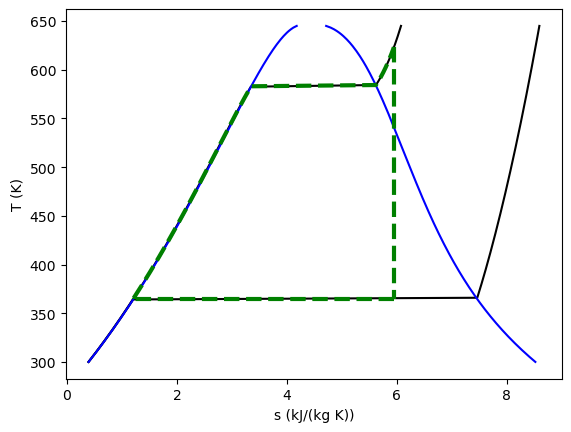

In [62]:
linewidth = 3

plt.figure()
plt.clf()
T = np.linspace(300, 372+273, 200) # range of temperatures
for P in [p3_MPa, p4_MPa]: #MPa
    steam = [IAPWS97(T=t, P=P) for t in T]
    S = [s.s for s in steam]
    plt.plot(S, T, 'k-')

# saturated vapor and liquid entropy lines
svap = [s.s for s in [IAPWS97(T=t, x=1) for t in T]]
sliq = [s.s for s in [IAPWS97(T=t, x=0) for t in T]]

plt.plot(svap, T, 'b-')
plt.plot(sliq, T, 'b-')

# plt.yscale('log')

plt.xlabel('s (kJ/(kg K))')
plt.ylabel('T (K)')

T23 = np.linspace(T2_K, T3_K,200)
S23 = [s.s for s in [IAPWS97(P=p2_MPa, T=t) for t in T23]]

# process 4 to 1. isobaric. 
T41 = np.linspace(T4_K, T1_K, 200) 
x41 = np.linspace(quality_4, quality_1, 200) 
S41 = [s.s for s in [IAPWS97(P=p1_MPa, x=t) for t in x41]]

plt.plot([state1.s, state2.s], [T1_K, T2_K], 'g--', lw=linewidth) # Path 1 to 2
plt.plot(S23, T23, 'g--', lw=linewidth) # path from 2 to 3 is isobaric
plt.plot([state3.s, state4.s], [T3_K, T4_K], 'g--', lw=linewidth) # path from 3 to 4 is isentropic
plt.plot(S41, T41, 'g--', lw=linewidth) # and from 4 to 1 is isobaric

plt.savefig('rankineCycle-T-s-diagram.png')